In [1]:
# windows only hack for graphviz path 
import os
for path in os.environ['PATH'].split(os.pathsep):
    if path.endswith("Library\\bin"):
        os.environ['PATH']+=os.pathsep+os.path.join(path, 'graphviz')

In [2]:
import tensorflow as tf
import numpy as np

# 下面兩個是用來輔助圖形化
from IPython.display import display
from tfdot import tfdot

## 常數及節點

In [3]:
tf.constant(42)

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [4]:
tf.constant(42.)

<tf.Tensor 'Const_1:0' shape=() dtype=float32>

In [5]:
tf.constant([42])

<tf.Tensor 'Const_2:0' shape=(1,) dtype=int32>

In [6]:
matrix1 = tf.constant([[3., 3.]])

matrix2 = tf.constant([[2.],[2.]])

matrix1, matrix2

(<tf.Tensor 'Const_3:0' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'Const_4:0' shape=(2, 1) dtype=float32>)

In [7]:
product = tf.matmul(matrix1, matrix2)
product

<tf.Tensor 'MatMul:0' shape=(1, 1) dtype=float32>

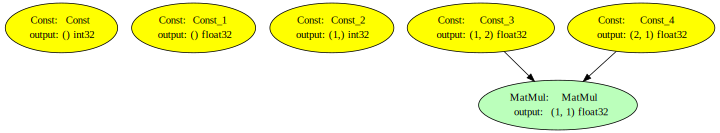

In [8]:
tfdot()

這些東西的單位叫做 graph

In [9]:
graph = tf.get_default_graph()
graph

In [10]:
product.graph

In [11]:
# 從 graph 得到 tensor
graph.get_tensor_by_name('MatMul:0')

<tf.Tensor 'MatMul:0' shape=(1, 1) dtype=float32>

## Q:
試試看其他名稱

### Operator

In [12]:
graph.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Const_3' type=Const>,
 <tf.Operation 'Const_4' type=Const>,
 <tf.Operation 'MatMul' type=MatMul>]

In [13]:
product.op

<tf.Operation 'MatMul' type=MatMul>

In [14]:
# 運算的輸出節點
product.op.outputs

[<tf.Tensor 'MatMul:0' shape=(1, 1) dtype=float32>]

In [15]:
# 運算的輸入節點
list(product.op.inputs)

[<tf.Tensor 'Const_3:0' shape=(1, 2) dtype=float32>,
 <tf.Tensor 'Const_4:0' shape=(2, 1) dtype=float32>]

## Q
* 試試看將 numpy ndarray 轉成 tf.constant
* 建立一個 matrix1 和 matrix2 逐項相乘的節點(猜一下是 tf.什麼)
* 用 `tf.reset_default_graph()` 清掉 default graph 看看，會發生什麼事情？
* 再跑一下 tfdot 看看

Tensor("Mul:0", shape=(2, 2), dtype=float32)


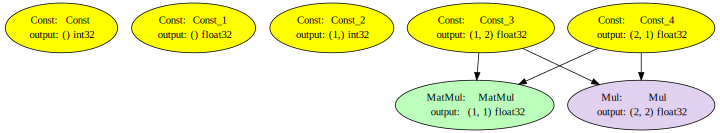

In [16]:
# 建立逐項相乘的參考方式
%run -i q_constant_mul.py
# 用
# %load q_constant_mul.py
# 可以看內容

## Session

如果圖是靜態的描述操作，動態的狀態就是 Session

In [17]:
# 建立一個 Session
sess = tf.Session()
# 在這個 Session 中執行 product 並且印出結果。
print(sess.run(product))
# 結束這個 Session
sess.close()

[[ 12.]]


### 也可以用 context manager 的寫法

In [18]:
with tf.Session() as sess:
    print(sess.run(product))
    # 也可以用
    print(product.eval())

[[ 12.]]
[[ 12.]]


## Q
* 用 numpy 檢查結果
* 把前面所有的 operation 都跑一遍

In [19]:
# 計算所有結果
%run -i q_run_all_op.py

Const [42]
Const_1 [42.0]
Const_2 [array([42], dtype=int32)]
Const_3 [array([[ 3.,  3.]], dtype=float32)]
Const_4 [array([[ 2.],
       [ 2.]], dtype=float32)]
MatMul [array([[ 12.]], dtype=float32)]
Mul [array([[ 6.,  6.],
       [ 6.,  6.]], dtype=float32)]


### Device context 
可以設定 device context

In [20]:
with tf.Session() as sess:
    with tf.device("/cpu:0"):
        print(sess.run(product))

[[ 12.]]


## Q
清掉前面的 default graph， 然後用不同的方式來計算 $1+2+\cdots+10$

* 用公式 $10\cdot(10+1)/2$
* 用 `tf.reduce_sum`
* 用 `tf.add_n`
* 用 `tf.matmul`
* 用 python 迴圈建立 graph


reduce_sum 55


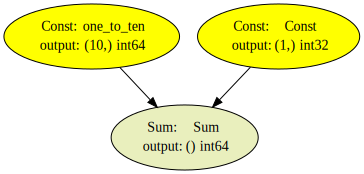

add_n 55


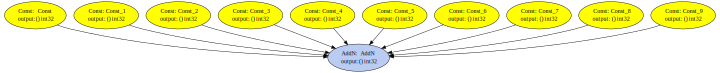

formula 55


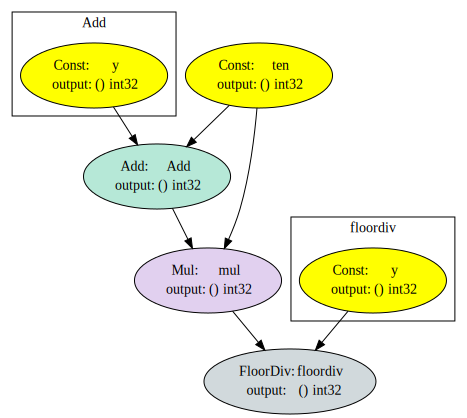

matmul [[ 55.]]


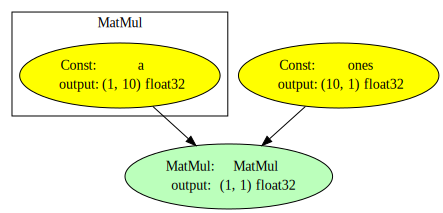

loop 55


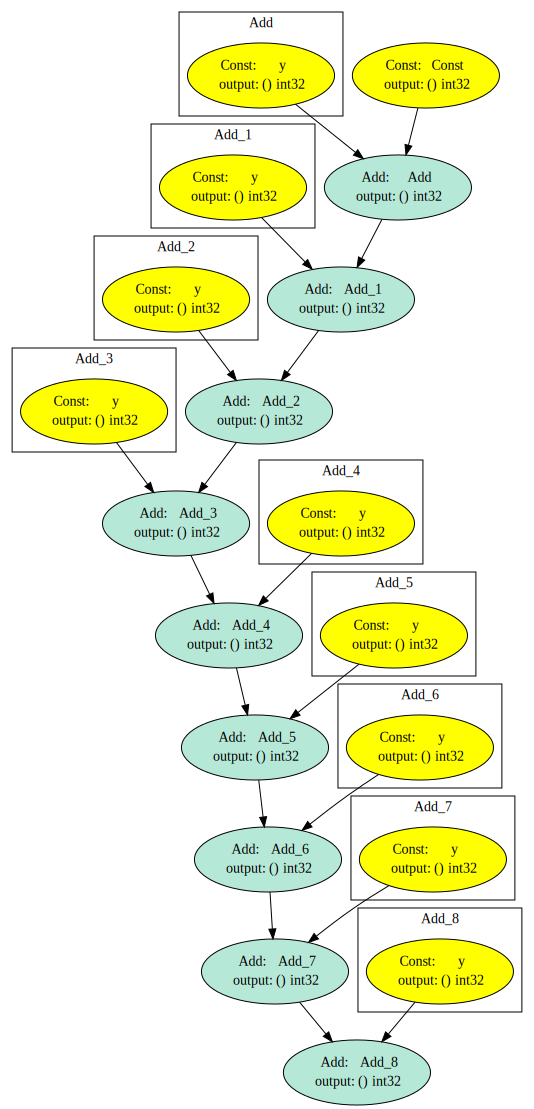

In [21]:
# 參考答案
%run -i q_sum.py

### Interactive session
在 notebook 中，可以用 interactive session， 就不用特別指名 session 了。 比較方便。

In [22]:
# 重新設定環境
tf.reset_default_graph()
# 設定 default session
sess =  tf.InteractiveSession()

常數太無聊， 試試看可以改變輸入的運算

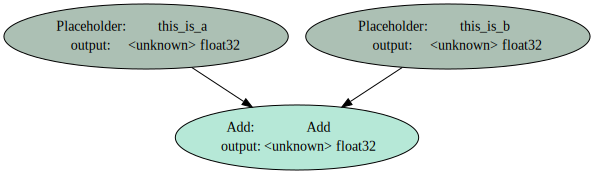

<tf.Tensor 'Add:0' shape=<unknown> dtype=float32>

In [23]:
# place holder, 先佔位子
a = tf.placeholder(tf.float32, name="this_is_a")
b = tf.placeholder(tf.float32, name="this_is_b")
s = tf.add(a, b)
display(tfdot())
s

直接執行
```python
s.eval()
```
會爆掉，因為佔了位子沒人來

所以要放東西進去

In [24]:
s.eval({a:2, b: 5})

7.0

或者

In [25]:
sess.run(s, {a:[1,2], b:[3,4]})

array([ 4.,  6.], dtype=float32)

In [26]:
sess.close()

## Variable
傳遞資訊不是免費的

變數：存東西在 session 的空間


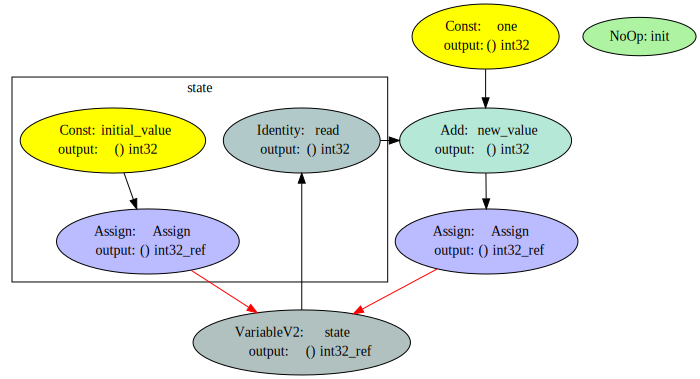

In [27]:
# 重新設定 graph 環境和 default session
tf.reset_default_graph()
sess = tf.InteractiveSession()
# 計數器
state = tf.Variable(0, name="state")

# 新的節點 計數器+1
new_value =  tf.add(state, tf.constant(1, name='one'), name='new_value')
# 更新 state
update = tf.assign(state, new_value)
# 變數初始化，這也是一個節點
init_op = tf.global_variables_initializer()
tfdot()

上面都是靜態的，下面才開始在 session 中執行

In [28]:
init_op.run()
# or sess.run(init_op)
print(state.eval())

0


In [29]:
for _ in range(300):
    #執行更新
    print(update.eval())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [30]:
state.eval()

300

In [31]:
sess.run([update]*10)

[301, 301, 301, 301, 301, 301, 301, 301, 301, 301]

In [32]:
sess.close()

### Initialize from another variable

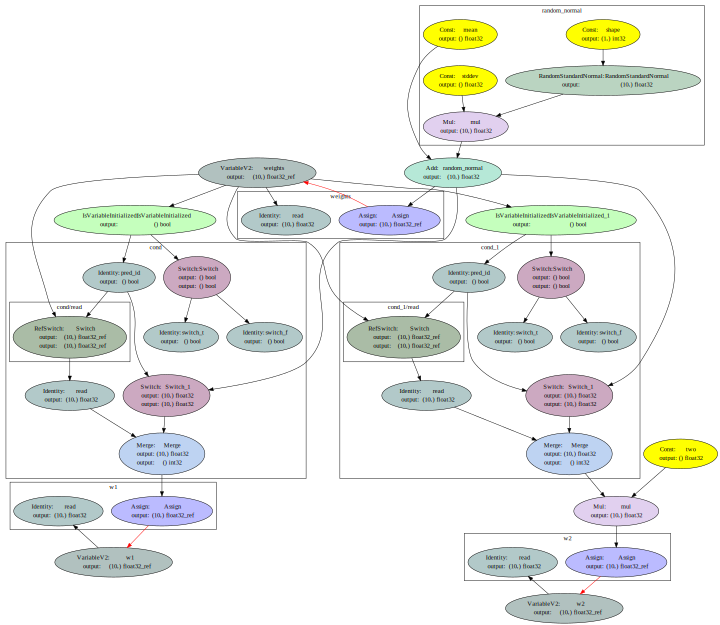

In [33]:
# 重設環境
tf.reset_default_graph()
sess = tf.InteractiveSession()

# 第一個變數 weights
weights = tf.Variable(tf.random_normal((10,), stddev=0.35), name='weights')
# 想要讓 w2 的初始值設定成和 weights 一樣 
w1 = tf.Variable(weights.initialized_value(), name ='w1')
# 想將 w_twice 設定為 weights 的兩倍
w2 = tf.Variable(weights.initialized_value()*tf.constant(2., name='two'), name="w2")
tfdot()

In [34]:
init_op = tf.global_variables_initializer()
init_op.run()

for v in tf.global_variables():
    print(v.name, v)
    print(v.eval())
    

weights:0 <tf.Variable 'weights:0' shape=(10,) dtype=float32_ref>
[-0.54788792 -0.43327531 -0.74471974  0.14002874 -0.3173947  -0.4651747
 -0.1881638  -0.35356027  0.14074554 -0.3372086 ]
w1:0 <tf.Variable 'w1:0' shape=(10,) dtype=float32_ref>
[-0.54788792 -0.43327531 -0.74471974  0.14002874 -0.3173947  -0.4651747
 -0.1881638  -0.35356027  0.14074554 -0.3372086 ]
w2:0 <tf.Variable 'w2:0' shape=(10,) dtype=float32_ref>
[-1.09577584 -0.86655062 -1.48943949  0.28005749 -0.63478941 -0.93034941
 -0.3763276  -0.70712054  0.28149107 -0.6744172 ]


In [35]:
sess.close()

### 流程控制
https://www.tensorflow.org/api_guides/python/control_flow_ops